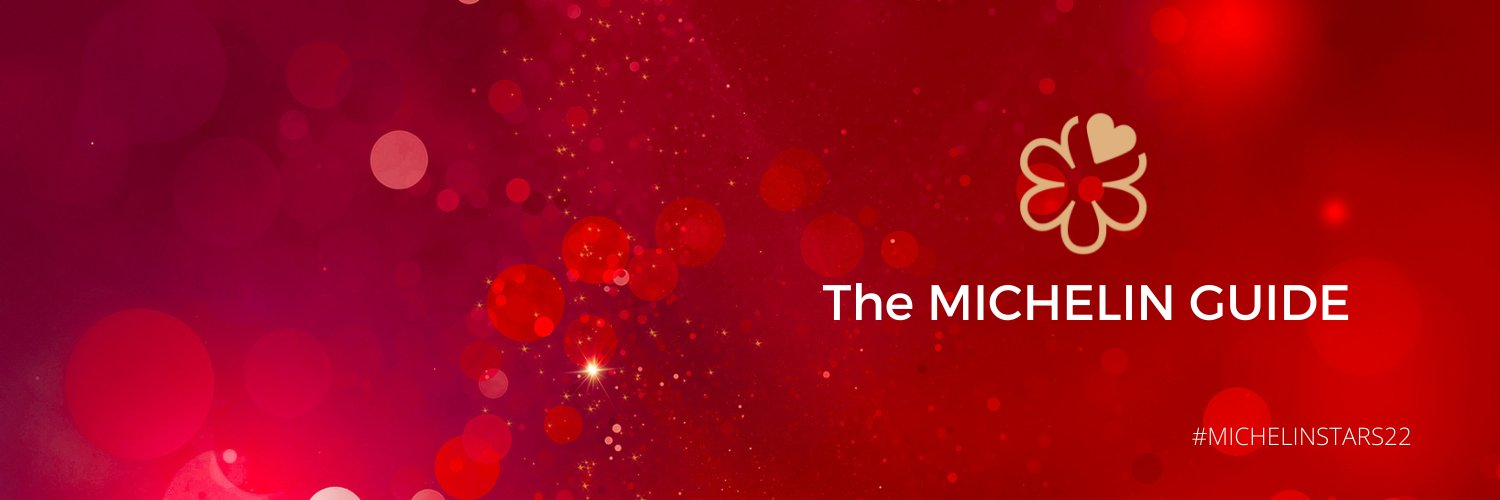

# MICHELIN RESTAURANT INSIGHTS

## About this Dataset
#### Context
Automatically update the annually update Michelin's Guide to restaurants around the world.

#### Content
Three files:
one-star-michelin-restaurants: contains info for the one Michelin star restaurants
two-stars-michelin-restaurants: contains info for the two Michelin stars restaurants
three-stars-michelin-restaurants: contains info for the three Michelin stars restaurants

#### Caveat
Currently, the data only contains restaurant info in the following regions:
Austria, California, Chicago, Croatia, Czech Republic, Denmark, Finland, Greece, Hong Kong, Hungary, Iceland, Macau, Norway, New York City, Poland, Ireland, Rio de Janeiro, Sao Paulo, South Korea, Singapore, Sweden, Taipei, Thailand, Washington DC, and United Kingdom and explicitly not including these regions: Belgium, France, Germany, Italy, Japan, Luxembourg, Netherlands,

# Imports and Data Reading

In [710]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import missingno as msno
import seaborn as sns
import geopy
import itertools
import geopy.distance
import geopandas as gpd
from shapely.geometry import Point
import pyogrio

In [3]:
# set the data path
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/michelin_restaurants/three-stars-michelin-restaurants.csv
./kaggle/input/michelin_restaurants/one-star-michelin-restaurants.csv
./kaggle/input/michelin_restaurants/two-stars-michelin-restaurants.csv


In [8]:
# Load the data 

# Load 1 star restaurants
one_star = pd.read_csv("./kaggle/input/michelin_restaurants/one-star-michelin-restaurants.csv") 

# Load 2 star restaurants
two_star = pd.read_csv("./kaggle/input/michelin_restaurants/two-stars-michelin-restaurants.csv")

# Load 3 star restaurants
three_star = pd.read_csv("./kaggle/input/michelin_restaurants/three-stars-michelin-restaurants.csv")


In [9]:
one_star.head()

,name,year,latitude,longitude,city,region,zipCode,cuisine,price,url
0,Kilian Stuba,2019,47.348580,10.17114,Kleinwalsertal,Austria,87568,Creative,$$$$$,https://guide.michelin.com/at/en/vorarlberg/kl...
1,Pfefferschiff,2019,47.837870,13.07917,Hallwang,Austria,5300,Classic cuisine,$$$$$,https://guide.michelin.com/at/en/salzburg-regi...
2,Esszimmer,2019,47.806850,13.03409,Salzburg,Austria,5020,Creative,$$$$$,https://guide.michelin.com/at/en/salzburg-regi...
3,Carpe Diem,2019,47.800010,13.04006,Salzburg,Austria,5020,Market cuisine,$$$$$,https://guide.michelin.com/at/en/salzburg-regi...
4,Edvard,2019,48.216503,16.36852,Wien,Austria,1010,Modern cuisine,$$$$,https://guide.michelin.com/at/en/vienna/wien/r...


# DATA PREPROCESSING

## Concat Datasets 

In [63]:
one_star.loc[:,'Michelin_Star'] = 1 
two_star.loc[:,'Michelin_Star'] = 2 
three_star.loc[:,'Michelin_Star'] = 3 

In [64]:
# number of restaurant for each star category
print(' 1-star restaurans: ',one_star.shape[0],'\n',
      '2-star restaurans: ',two_star.shape[0],'\n',
      '3-star restaurans: ',three_star.shape[0],'\n',
      'total number of  restaurans: ',one_star.shape[0] + two_star.shape[0] + three_star.shape[0])
      

 1-star restaurans:  549 
 2-star restaurans:  110 
 3-star restaurans:  36 
 total number of  restaurans:  695


In [717]:
# compile the list of dataframes you want to concat
frames = [one_star, two_star, three_star]

# concat them 
df_concated = pd.concat(frames, axis=0)
df_concated.head()
df = df_concated.copy()

In [718]:
# reset indexes
df.reset_index(inplace=True, drop=True)

# check the index
df.tail(5)

,name,year,latitude,longitude,city,region,zipCode,cuisine,price,url,Michelin_Star
690,Fat Duck,2019,51.508280,-0.702320,Bray,United Kingdom,SL6 2AQ,Creative,NaN,https://guide.michelin.com/gb/en/buckinghamshi...,3
691,Waterside Inn,2019,51.507730,-0.701210,Bray,United Kingdom,SL6 2AT,Classic French,NaN,https://guide.michelin.com/gb/en/buckinghamshi...,3
692,Alain Ducasse at The Dorchester,2019,51.507120,-0.152520,Mayfair,United Kingdom,W1K 1QA,French,NaN,https://guide.michelin.com/gb/en/greater-londo...,3
693,The Araki,2019,51.511826,-0.140389,Mayfair,United Kingdom,W1S 3BF,Japanese,NaN,https://guide.michelin.com/gb/en/greater-londo...,3
694,Gordon Ramsay,2019,51.485460,-0.162020,Chelsea,United Kingdom,SW3 4HP,French,NaN,https://guide.michelin.com/gb/en/greater-londo...,3


In [303]:
df.shape

(695, 11)

In [304]:
# check general dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           695 non-null    object 
 1   year           695 non-null    int64  
 2   latitude       695 non-null    float64
 3   longitude      695 non-null    float64
 4   city           693 non-null    object 
 5   region         695 non-null    object 
 6   zipCode        501 non-null    object 
 7   cuisine        695 non-null    object 
 8   price          519 non-null    object 
 9   url            695 non-null    object 
 10  Michelin_Star  695 non-null    int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 59.9+ KB


There are 3 numeric 8 categorical features showed, but it is critical to check catogoric variables' high-cardinality and if the numerical variable is actually a categorical variable.

In [305]:
def grab_col_names(dataframe, cat_th=10, car_th=50):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                categorical columns
        num_cols: list
                Numerical columns
        cat_but_car: list
                Categorical view cardinal variable list
                
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable number
        num_but_cat is in cat_cols
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 695
Variables: 11
cat_cols: 4
num_cols: 2
cat_but_car: 5
num_but_cat: 2


In [306]:
print('categorical columns : ',cat_cols)
print('Numerical columns : ',num_cols)
print('High Cardinality columns : ',cat_but_car) # categorical features which has more than 50 categories

categorical columns :  ['region', 'price', 'year', 'Michelin_Star']
Numerical columns :  ['latitude', 'longitude']
High Cardinality columns :  ['name', 'city', 'zipCode', 'cuisine', 'url']


##### Missing values analysis


In [307]:
df.isnull().sum()

name               0
year               0
latitude           0
longitude          0
city               2
region             0
zipCode          194
cuisine            0
price            176
url                0
Michelin_Star      0
dtype: int64

<AxesSubplot:>

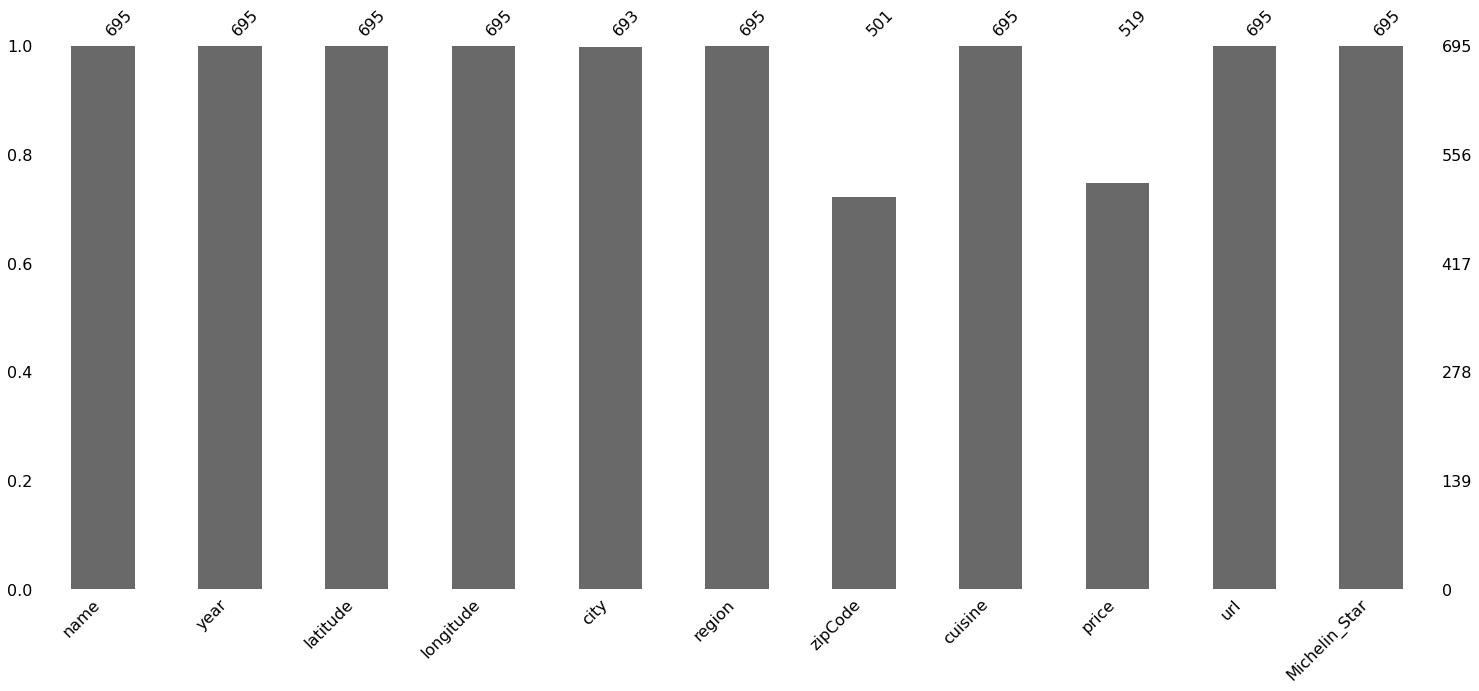

In [308]:
msno.bar(df)

Price and Zipcode has critical number of missing values

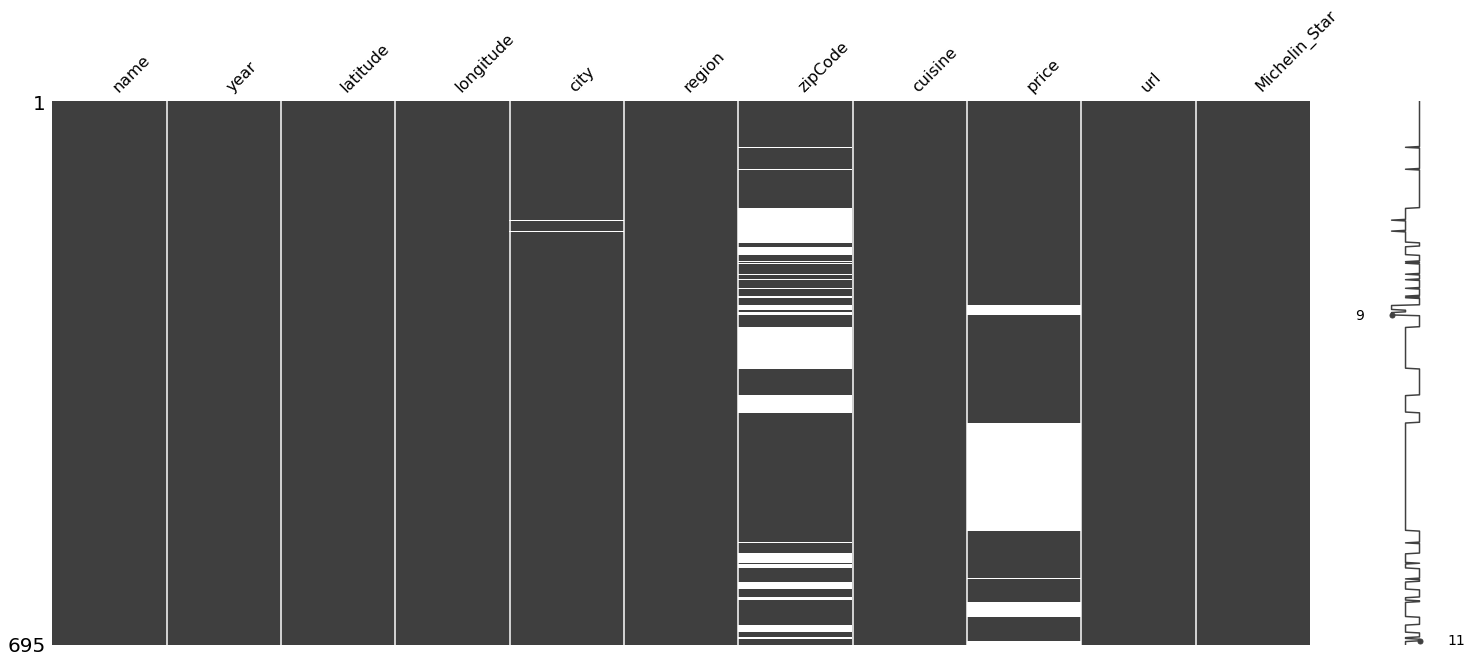

In [309]:
# Check if there is any realtion in between missingnes
msno.matrix(df);

some parts where price is missing zipCode is not, there seems minimal negative correlation in between them

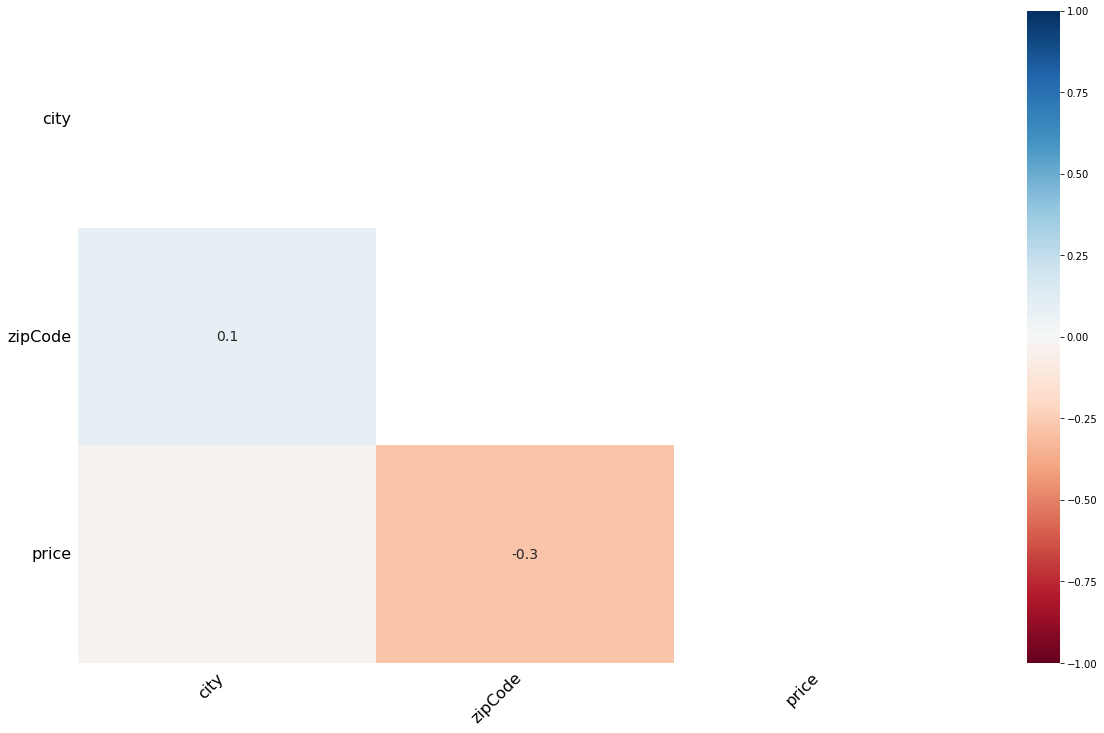

In [310]:
# missing correlation check
msno.heatmap(df);

As we suspect there is a minimal negative corr in between zipCode and price.

In [311]:
print('DISTRIBUTION : \n\n',df.price.value_counts(dropna=False), '\n\n') # number of different categories and total number of null
print('DISTRIBUTION PERCENTAGES : \n\n',df.price.value_counts(normalize=True,dropna=False)*100)

DISTRIBUTION : 

 $$$$     197
NaN      176
$$$      143
$$        75
$$$$$     73
$         31
Name: price, dtype: int64 


DISTRIBUTION PERCENTAGES : 

 $$$$     28.345324
NaN      25.323741
$$$      20.575540
$$       10.791367
$$$$$    10.503597
$         4.460432
Name: price, dtype: float64


number of dolar signs are representing the expensiveness range
We can either try to inpute or give another category name called missing. For current situation I decide to go with creating null class for this categorical column, in order to avoid bias towards most frequent observation.

In [719]:
df['price'] = df[['price']].apply(lambda x: len(x[0]) if pd.notnull(x[0]) else np.nan, axis=1)

In [720]:
df.price.value_counts(dropna=False)

4.0    197
NaN    176
3.0    143
2.0     75
5.0     73
1.0     31
Name: price, dtype: int64

##### Zipcode missing value inputation using lat and long 


In [721]:
for ind, val in enumerate(df.zipCode) :
    if pd.isnull(val):
        geo_locator = geopy.Nominatim(user_agent = '1234')
        r = geo_locator.reverse((df.loc[ind, 'latitude'], df.loc[ind, 'longitude']))
        try : 
            df.loc[ind, 'zipCode'] = r.raw['address']['postcode']
        except:
            pass

In [722]:
df['zipCode'].isnull().sum()

64

In [723]:
df[df['zipCode'].isnull()].city.value_counts()

Hong Kong    61
Singapore     1
Name: city, dtype: int64

nearly all of the missing zipcodes are in Hong Kong region. In order to fill it we will use closest zipcode to that area using their latitude and longitude and calculate the minumum difference

In [724]:

missing_zip_index = df[df['zipCode'].isnull()].index
distance_dic = dict.fromkeys(missing_zip_index, [])

for miss_ind in missing_zip_index :
    
    coord1 = (df.loc[miss_ind, 'latitude'], df.loc[miss_ind, 'longitude'])
   
    for ind in df.index:
        
        if (ind == miss_ind) or (pd.isnull(df.loc[ind, 'zipCode'])) :  # besides miss_ind itself and zipcode null values
            continue
        
        else:
        
            coord2 = (df.loc[ind, 'latitude'], df.loc[ind, 'longitude'])
            diff = geopy.distance.geodesic(coord1, coord2).km

            if distance_dic[miss_ind] == [] :  # if it is the first check set the distance
                distance_dic[miss_ind] = [ind, diff]

            elif distance_dic[miss_ind][1] > diff :  # if the difference is smaller than previous distance set as new small 
                distance_dic[miss_ind] = [ind, diff]


In [725]:
# first 5 rows : 
dict(itertools.islice(distance_dic.items(), 5))

{137: [678, 76.99825839791325],
 138: [678, 70.17846963058479],
 139: [678, 64.89935591449328],
 140: [678, 65.10299387717964],
 141: [678, 64.84490675786924]}

In [726]:
# now we are going to set the new zipcodes according to nearest neighbor zipcode

for ind in missing_zip_index :
    df.loc[ind, 'zipCode'] = df.loc[distance_dic[ind][0], 'zipCode']

df['zipCode'].isnull().sum()

0

##### Missing price ranges inputation

The same mindset can be used for restaurants also because generally closer restaurants have similar price ranges. Lux restaurants generally are in the same region. Therefore, considering this true I will set price level for missing values with nearest restaurant.

In [727]:
# I will use same algorithm for missing zipcode but with nearest restaurant :
missing_price_index = df[df['price'].isnull()].index
distance_dic = dict.fromkeys(missing_price_index, [])

for miss_ind in missing_price_index :
    
    coord1 = (df.loc[miss_ind, 'latitude'], df.loc[miss_ind, 'longitude'])
   
    for ind in df.index:
        
        if (ind == miss_ind) or (pd.isnull(df.loc[ind, 'price'])) :  # besides miss_ind itself and price null values
            continue
        
        else:
        
            coord2 = (df.loc[ind, 'latitude'], df.loc[ind, 'longitude'])
            diff = geopy.distance.geodesic(coord1, coord2).km

            if distance_dic[miss_ind] == [] :  # if it is the first check set the distance
                distance_dic[miss_ind] = [ind, diff]

            elif distance_dic[miss_ind][1] > diff :  # if the difference is smaller than previous distance set as new small 
                distance_dic[miss_ind] = [ind, diff]
                
# now we are going to set the new price level according to nearest neighbor price range

for ind in missing_price_index :
    df.loc[ind, 'price'] = df.loc[distance_dic[ind][0], 'price']

df['price'].isnull().sum()

0

##### City missing inputation

In [728]:
df[df['city'].isnull()==True]

,name,year,latitude,longitude,city,region,zipCode,cuisine,price,url,Michelin_Star
152,Épure,2019,22.295830,114.169304,NaN,Hong Kong,999078,French,3.0,https://guide.michelin.com/hk/en/hong-kong-reg...,1
166,Arbor,2019,22.283146,114.155420,NaN,Hong Kong,999078,Innovative,3.0,https://guide.michelin.com/hk/en/hong-kong-reg...,1


In [729]:
# change the missing cities with correct ones : 

for ind in [152, 166] :
    geo_locator = geopy.Nominatim(user_agent = '1234')
    r = geo_locator.reverse((df.loc[ind, 'latitude'], df.loc[ind, 'longitude']))
    try : 
        df.loc[ind, 'city'] = r.raw['address']['city']
    except:
        pass
    
df['city'].isnull().any()

False

In [730]:
df.isnull().any()

name             False
year             False
latitude         False
longitude        False
city             False
region           False
zipCode          False
cuisine          False
price            False
url              False
Michelin_Star    False
dtype: bool

Finaly we get rid of all null values! 

#### Get the continent names from country names

In [731]:
df["Coordinates"] = list(zip(df.longitude, df.latitude)) # get tuple lat and long
df["Coordinates"] = df["Coordinates"].apply(Point) # turn the tuple into a Shapely Point object.


In [732]:
#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = '' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'America' 
    return cn_a2_code, cn_continent

In [733]:
df['continent'] = df['region'].apply(lambda x: get_continent(x)[1])

In [734]:
df.continent.value_counts()

EU         278
America    244
AS         173
Name: continent, dtype: int64

In [735]:
df.year.value_counts()

2019    656
2018     39
Name: year, dtype: int64

Since there is only 39 2018th year we will assume there are no difference in between these year ranges. As if all 2019 

In [736]:
df.drop('year',inplace=True, axis=1)

In [737]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           695 non-null    object 
 1   latitude       695 non-null    float64
 2   longitude      695 non-null    float64
 3   city           695 non-null    object 
 4   region         695 non-null    object 
 5   zipCode        695 non-null    object 
 6   cuisine        695 non-null    object 
 7   price          695 non-null    float64
 8   url            695 non-null    object 
 9   Michelin_Star  695 non-null    int64  
 10  Coordinates    695 non-null    object 
 11  continent      695 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 65.3+ KB


In [1106]:
df['region'].value_counts()

United Kingdom    162
California         90
New York City      74
Hong Kong          63
Singapore          39
Denmark            28
South Korea        26
Thailand           26
Taipei             24
Sweden             22
Chicago            22
Austria            19
Macau              19
Washington DC      16
Ireland            14
Sao Paulo          12
Norway              8
Hungary             6
Rio de Janeiro      6
Finland             6
Croatia             5
Greece              4
Czech Republic      2
Poland              2
Name: region, dtype: int64

#### Primary Key Detector

In [738]:
df[df.name == 'L\'Atelier de Joël Robuchon']

# here we observe different stars with same named restaurant in different countries. So, we can not assign name as unique identifier

,name,latitude,longitude,city,region,zipCode,cuisine,price,url,Michelin_Star,Coordinates,continent
360,L'Atelier de Joël Robuchon,25.039188,121.56771,Taipei,Taipei,110,French contemporary,3.0,https://guide.michelin.com/tw/en/taipei-region...,1,POINT (121.56771 25.039188),America
596,L'Atelier de Joël Robuchon,40.742905,-74.00769,New York,New York City,10019,French,4.0,https://guide.michelin.com/us/en/new-york-stat...,2,POINT (-74.00769 40.742905),America
674,L'Atelier de Joël Robuchon,22.281199,114.15816,Hong Kong,Hong Kong,999078,French contemporary,4.0,https://guide.michelin.com/hk/en/hong-kong-reg...,3,POINT (114.15816 22.281199),AS


What is the primary key : 

Either we can set name and city as composite primary key or we can set url as primary key

In [739]:
sum(df.groupby('name')['city'].value_counts()==1) # here we check if there is any duplicated restaurant same city same name

695

In [740]:
(df['name']+df['city']).nunique() # composite primary key name and city

695

In [741]:
df['url'].nunique() # unique identifier URL

695

In [802]:
df.cuisine.nunique()

70

In [856]:
cuisines

array(['Creative', 'Classic cuisine', 'Market cuisine', 'Modern cuisine',
       'Japanese', 'Vegetarian', 'Contemporary', 'Indian', 'Korean',
       'Californian', 'American', 'International', 'Moroccan', 'Thai',
       'Chinese', 'Fusion', 'Italian', 'French', 'Asian', 'Steakhouse',
       'Mexican', 'Gastropub', 'Danish', 'Classic French', 'Finnish',
       'Mediterranean', 'Seafood', 'Cantonese', 'Dim Sum', 'Teppanyaki',
       'Sushi', 'Shanghainese', 'Noodles and congee', 'Innovative',
       'Cantonese Roast Meats', 'Taizhou', 'Sichuan',
       'European contemporary', 'Scandinavian', 'Austrian', 'Spanish',
       'Modern British', 'modern', 'Asian influences', 'creative',
       'French contemporary', 'Korean contemporary', 'Temple cuisine',
       'Street Food', 'Fujian', 'Australian', 'Italian contemporary',
       'Barbecue', 'Peranakan', 'Meats and grills', 'Taiwanese',
       'Hang Zhou', 'Asian contemporary', 'Thai Contemporary',
       'Southern Thai', 'European', 'Creat

In [863]:
cuisines = df.cuisine.unique()

# rough categorization 
cuisines_cat = {'Creative-Modern':['Creative','Modern cuisine','Contemporary','modern','Innovative',
                                   'Gastropub','Fusion','Market cuisine','creative'],
                'Asian':['Japanese','Indian','Korean','Thai','Asian','Chinese','Sushi','Noodles and congee','Dim Sum',
                         'Teppanyaki','Sichuan','Taizhou','Cantonese','Sichuan-Huai Yang','Southern Thai','Hang Zhou',
                         'Japanese contemporary','Shanghainese','Asian influences','Fujian','Taiwanese','Temple cuisine',
                         'Thai Contemporary','Peranakan','Hunanese and Sichuan','Korean contemporary','Asian contemporary',
                         'Cantonese Roast Meats'],
                'European':['French','French contemporary','Creative British','Modern French','Traditional British',
                            'Danish','Scandinavian','Austrian','Classic French','Creative French','European','Finnish',
                            'European contemporary','Modern British'],
                'Mediterian':['Italian','Spanish','Mediterranean cuisine','Italian contemporary','Vegetarian',
                              'Mediterranean','Moroccan'],
                'Classic and Others': ['Classic cuisine','Australian','Meats and grills','Street Food','Barbecue',
                                      'Steakhouse','American','Californian','International','Mexican','Regional cuisine',
                                       'Seafood']}



In [864]:
df['cuisines_cat'] = '' 
for ind in range(len(df)):
    for k,v in cuisines_cat.items() : 
        if df.loc[ind,'cuisine'] in v:
            df.loc[ind,'cuisines_cat'] = k


In [842]:
df.head(3)

,name,latitude,longitude,city,region,zipCode,cuisine,price,url,Michelin_Star,Coordinates,continent,cuisines_cat
0,Kilian Stuba,47.34858,10.17114,Kleinwalsertal,Austria,87568,Creative,5.0,https://guide.michelin.com/at/en/vorarlberg/kl...,1,POINT (10.17114 47.34858),EU,Creative-Modern
1,Pfefferschiff,47.83787,13.07917,Hallwang,Austria,5300,Classic cuisine,5.0,https://guide.michelin.com/at/en/salzburg-regi...,1,POINT (13.07917 47.83787),EU,Classic and Others
2,Esszimmer,47.80685,13.03409,Salzburg,Austria,5020,Creative,5.0,https://guide.michelin.com/at/en/salzburg-regi...,1,POINT (13.03409 47.80685),EU,Creative-Modern


In [866]:
Cuisines_agg = df.groupby(['city','cuisines_cat'])[['url']].count().reset_index()
Cuisines_agg.columns = ['city','cuisine_categorical','number_of_rest']
Cuisines_agg

,city,cuisine_categorical,number_of_rest
0,Aarhus,Creative-Modern,4
1,Aird Mhór/Ardmore,Creative-Modern,1
2,Anstruther,Creative-Modern,1
3,Ascot,Creative-Modern,1
4,Athína,Classic and Others,1
...,...,...,...
258,Winteringham,Creative-Modern,1
259,Zagreb,Creative-Modern,1
260,Šibenik,Creative-Modern,1
261,九龍 Kowloon,European,1


In [867]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  

import plotly.graph_objects as go

    
fig = go.Figure(data=[go.Bar(x=Cuisines_agg['cuisine_categorical'], 
                             y=Cuisines_agg['number_of_rest'])],
                             layout_title_text= "number_of_rest" + " per " + "cuisine_categorical")
fig.show()

# DATA ANALYSIS 

## 1. Identifying the most relevant countries and cities in Europe and bringing the insights I find more valuable.

In [742]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(df)):
        lat = df.iloc[i]['latitude']
        long = df.iloc[i]['longitude']
        radius=5
        popup_text = """Country : {}<br>
                    %of Users : {}<br>"""
        popup_text = popup_text.format(df.iloc[i]['region'],
                                   df.iloc[i]['Michelin_Star']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

In [868]:
df[df['continent']=='EU'].shape # 278 European Michelin Restaurants

(278, 13)

In [869]:
def based_aggregator(dataframe, aggregator= 'region', continent='EU'):
    
    df_agg = dataframe[dataframe['continent'] == 'EU'].groupby([aggregator]).agg({'Michelin_Star':['mean','count'],
                                            'price' : ['mean', 'median']})
    df_agg = df_agg.reset_index(level=0)
    df_agg.columns = [aggregator, 'Star_mean', 'number_of_rest', 'price_mean', 'price_median']
    df_agg.sort_values(by = ['Star_mean', 'price_mean', 'price_median'], ascending = False, inplace=True)
    df_agg['Star-Price_Ratio'] = df_agg['Star_mean']/df_agg['price_mean']
    
    return df_agg


In [870]:
df_agg = based_aggregator(df)
df_agg

,region,Star_mean,number_of_rest,price_mean,price_median,Star-Price_Ratio
0,Austria,1.421053,19,4.947368,5.0,0.287234
10,Sweden,1.318182,22,3.363636,3.0,0.391892
5,Greece,1.250000,4,5.000000,5.0,0.250000
8,Norway,1.250000,8,3.750000,4.0,0.333333
3,Denmark,1.250000,28,3.142857,3.0,0.397727
11,United Kingdom,1.179012,162,3.092593,3.0,0.381238
6,Hungary,1.166667,6,4.333333,4.5,0.269231
7,Ireland,1.071429,14,3.785714,4.0,0.283019
1,Croatia,1.000000,5,5.000000,5.0,0.200000
2,Czech Republic,1.000000,2,5.000000,5.0,0.200000


In [871]:
most_important = ['United Kingdom', 'Denmark', 'Sweden', 'Austria', 'Ireland']
df_agg_filtered = df_agg[df_agg.region.isin(most_important)]
df_agg_filtered

,region,Star_mean,number_of_rest,price_mean,price_median,Star-Price_Ratio
0,Austria,1.421053,19,4.947368,5.0,0.287234
10,Sweden,1.318182,22,3.363636,3.0,0.391892
3,Denmark,1.250000,28,3.142857,3.0,0.397727
11,United Kingdom,1.179012,162,3.092593,3.0,0.381238
7,Ireland,1.071429,14,3.785714,4.0,0.283019


In [872]:
dff_agg_city =  based_aggregator(df, aggregator='city')
dff_agg_city.head(10)

,city,Star_mean,number_of_rest,price_mean,price_median,Star-Price_Ratio
22,Bray,2.333333,3,3.0,3.0,0.777778
5,Auchterarder,2.000000,1,4.0,4.0,0.500000
69,Järpen,2.000000,1,4.0,4.0,0.500000
79,Leynar,2.000000,1,4.0,4.0,0.500000
123,Skåne-Tranås,2.000000,1,4.0,4.0,0.500000
6,Aughton,2.000000,1,3.0,3.0,0.666667
26,Cambridge,2.000000,1,3.0,3.0,0.666667
56,Great Milton,2.000000,1,3.0,3.0,0.666667
63,Henne,2.000000,1,3.0,3.0,0.666667
66,Hyde Park,2.000000,1,3.0,3.0,0.666667


In [873]:
def agg_bar_plotter(agg_df, aggregator='region', y='number_of_rest'):

    import plotly.express as px
    from plotly.offline import init_notebook_mode, iplot
    init_notebook_mode(connected=True)  

    import plotly.graph_objects as go

    fig = go.Figure(
        data=[go.Bar(x=agg_df[aggregator], y=agg_df[y])],
        layout_title_text= y + " per " + aggregator
    )
    fig.show()


In [874]:
agg_bar_plotter(dff_agg_city, aggregator='city')
agg_bar_plotter(dff_agg_city, aggregator='city', y = 'Star_mean')
agg_bar_plotter(dff_agg_city, aggregator='city', y = 'price_mean')


# Most critical country's Individual Analysis

In [877]:
from tabulate import tabulate
for country in most_important : 
    region = pd.pivot_table(df[df.region==country], 
                            values=['Michelin_Star','price'], 
                            index=['city'], 
                            aggfunc={'Michelin_Star':['count','mean'], 
                                      'price': 'mean'}).reset_index()
    region.columns = ['city', 'Numb of Restaurant', 'Star Mean', 'price mean']
    region.sort_values(by = ['Numb of Restaurant', 'Star Mean'], ascending=False, inplace=True)
    region['Price-Star_Ratio'] = round(region['price mean']/region['Star Mean'],1)  # given price to achieved Michelin Point Scoring Quality 
    the_city = region['city'][0]  # city with highest number of restaurants
    
    # most common cuisine in the country
    most_common_cuisine_in_country = df[df.region==country].groupby('cuisine').agg({'url':'count'}).reset_index()
    most_common_cuisine_in_country.columns = ['cuisine', 'cuisine_count']
    most_common_cuisine_in_country.sort_values(by = 'cuisine_count', ascending=False, inplace=True)
    
    # most common cuisine category in the country 

    most_common_cuisine_cat_in_country = df[df.region==country].groupby('cuisines_cat').agg({'url':'count'}).reset_index()
    most_common_cuisine_cat_in_country.columns = ['cuisines_cat', 'cuisine_count']
    most_common_cuisine_cat_in_country.sort_values(by = 'cuisine_count', ascending=False, inplace=True)
    
    
    # most common cuisine in the city with highest number of Michelin restaurants
    most_com_cuisine_in_city = df[df.city==the_city].groupby('cuisine').agg({'url':'count'}).reset_index()
    most_com_cuisine_in_city.columns = ['cuisine', 'cuisine_count']
    most_com_cuisine_in_city.sort_values(by = 'cuisine_count', ascending=False, inplace=True)
    
    # most common cuisine category in the city 
    most_com_cuisine_cat_in_city = df[df.city==the_city].groupby('cuisines_cat').agg({'url':'count'}).reset_index()
    most_com_cuisine_cat_in_city.columns = ['cuisines_cat', 'cuisine_count']
    most_com_cuisine_cat_in_city.sort_values(by = 'cuisine_count', ascending=False, inplace=True)
    
    
    print('TOP 5 ******************', country.upper(),  '******************\n')
    print( 'Most common sub category cusine in the country : \n', most_common_cuisine_in_country.loc[0,'cuisine'], '\n\n')
    print( 'Most common sub category cusine in the city : \n ', most_com_cuisine_in_city.loc[0,'cuisine'], '\n\n')
    print( 'Most common cusine category in the country : \n', most_common_cuisine_cat_in_country.loc[0,'cuisines_cat'], '\n\n')
    print( 'Most common cusine category in the city : \n ', most_com_cuisine_cat_in_city.loc[0,'cuisines_cat'], '\n\n')
    print(tabulate(region[:5], headers='keys', tablefmt='psql'), end='\n\n')
    


TOP 5 ****************** UNITED KINGDOM ******************

Most common sub category cusine in the country : 
 Asian influences 


Most common sub category cusine in the city : 
  Modern cuisine 


Most common cusine category in the country : 
 Asian 


Most common cusine category in the city : 
  Creative-Modern 


+----+------------+----------------------+-------------+--------------+--------------------+
|    | city       |   Numb of Restaurant |   Star Mean |   price mean |   Price-Star_Ratio |
|----+------------+----------------------+-------------+--------------+--------------------|
| 66 | Mayfair    |                   19 |     1.47368 |            3 |                2   |
| 22 | Chelsea    |                    4 |     1.75    |            3 |                1.7 |
| 13 | Bloomsbury |                    4 |     1.25    |            3 |                2.4 |
|  8 | Belgravia  |                    4 |     1       |            3 |                3   |
| 12 | Birmingham |            

#### United Kingdom : 

162 Michelin Restaurants <br>
Most common sub category cusine in the country : Asian influences <br>

Top city : Mayfair <br>

City:

         - 19 restaurants 
         - price avg level 3 
         - Michelin star average 1.47 
         - price-star ratio 2
         - most-common sub category cuisine : Modern cuisine


#### Denmark : 

28 Michelin Restaurants <br>
Most common sub category cusine in the country : Classic French <br>

Top city : København <br>

City stats :

         - 17 restaurants 
         - price avg level 3 
         - Michelin star average 1.29 
         - price-star ratio 2.3
         - most-common sub category cuisine : Creative

         
         
#### Sweden : 

22 Michelin Restaurants <br>
Most common sub category cusine in the country : Classic cuisine <br>

Top city : Stockholm <br>

City stats :

         - 10 restaurants 
         - price avg level 3.5 
         - Michelin star average 1.4 
         - price-star ratio 2.5
         - most-common sub category cuisine : Classic cuisine
 


#### Austria : 

19 Michelin Restaurants <br>
Most common sub category cusine in the country : Classic cuisine <br>

Top city : Wien <br>

City Stats : 

         - 13 restaurants 
         - price avg level 4.92 
         - Michelin star average 1.46  
         - price-star ratio 3.4
         - most-common sub category cuisine : Classic cuisine

         


#### Ireland : 

14 Michelin Restaurants <br>
Most common sub category cusine in the country : Classic cuisine <br>

Top city : City Centre <br>

City Stats : 

         - 4 restaurants 
         - price avg level 4 
         - Michelin star average 1.25 
         - price-star ratio 3.2
         - most-common sub category cuisine : Modern cuisine
 
         

### 1. General Results
When we analyze on a country basis, <br>
the top 3 countries with the highest Michelin star average are Austria, Sweden and Greece. 

<br>
However, considering the number of restaurants, the top 5 countries are: <br>
United Kingdom (162), Denmark (28), Sweden (22), Austria (19) and Ireland (14). The number of restaurants in the remaining countries does not exceed 10 nationwide.

Based on the distribution I would suggest to focus on high volume countries since the highest average stars also includes two of them : 
* United Kingdom (162) 
* Denmark (28) 
* Sweden (22) 
* Austria (19)
* Ireland (14)

#### INSIGHTS : 

- United Kingdom has most distributed Michelin stared restaurant ranged among the dataset. <br>
- Out of top 5 cities Wien, Austria is the most expensive average price ranges among top city of the countries, Ireland city center is pretty close though
- On the other hand, Mayfair, UK has the best price-star(quality) ratio
- Top Cities generally prefer with Classic and Modern cuisine
- United Kingdom, among my top 5 EU countries, is the only one who has most common sub category cuisine as Asian Cuisine
- Asian cuisine category is very popular in nearly all european countries


## 2. City with most diverse offering in terms of availabe cuisine 


In [788]:
def cuisine_based_aggregator(dataframe, continent='EU', on_diversity_ratio = False, number_of_rest_th = 5):
    """
    Calculate cuisine diversity per city
    
    input dataframe : pandas dataframe
    input continent(optional) , continent filter
    
    returns : aggregated dataframe 
    number of unique cuisine per city
    """
    #df_agg = dataframe[dataframe['continent']==continent].groupby(['city'])[['cuisine']].nunique()
    df_agg = dataframe[dataframe['continent']==continent]\
                        .groupby(['city'])\
                        .agg({'cuisine':'nunique',
                              'Michelin_Star':'mean', 
                              'price': 'mean',
                              'url' : 'count'
                             })
    df_agg.reset_index(inplace=True)
    df_agg.columns=['city','cuisine_diversity_range','star-mean','price-mean', 'number_of_restaurants']
    df_agg['price-star ratio'] = round(df_agg['price-mean']/df_agg['star-mean'],1)
    df_agg['restaurant_number-cuisine_diversity ratio'] = round(df_agg['cuisine_diversity_range']/df_agg['number_of_restaurants'],1)
    
    if on_diversity_ratio :
        df_agg = df_agg[df_agg['number_of_restaurants']>=number_of_rest_th]
        df_agg = df_agg.sort_values(by=['restaurant_number-cuisine_diversity ratio'], 
                           ascending=False)
        return df_agg
    else :
        
        df_agg = df_agg.sort_values(by=['cuisine_diversity_range'], 
                           ascending=False)
        return df_agg

In [789]:
# TOP 3 diverse cuisine cities according to number of unique cuisine number: 

df_agg2 = cuisine_based_aggregator(df)
df_agg2.head(3) 

,city,cuisine_diversity_range,star-mean,price-mean,number_of_restaurants,price-star ratio,restaurant_number-cuisine_diversity ratio
92,Mayfair,11,1.473684,3.000000,19,2.0,0.6
75,København,6,1.294118,3.000000,17,2.3,0.4
142,Wien,5,1.461538,4.923077,13,3.4,0.4


In [794]:
agg_bar_plotter(df_agg2[df_agg2['number_of_restaurants']>=5], aggregator='city', y='cuisine_diversity_range')

In [795]:
# however, we need to also consider the ratio of unique cuisine and the number of restaurants in the restaurant

df_agg2 = cuisine_based_aggregator(df, on_diversity_ratio = True)
df_agg2.head(3) 

,city,cuisine_diversity_range,star-mean,price-mean,number_of_restaurants,price-star ratio,restaurant_number-cuisine_diversity ratio
92,Mayfair,11,1.473684,3.000000,19,2.0,0.6
57,Göteborg,3,1.000000,3.166667,6,3.2,0.5
128,Stockholm,5,1.400000,3.500000,10,2.5,0.5


In [796]:
agg_bar_plotter(df_agg2[df_agg2['number_of_restaurants']>=5], 
                aggregator='city', 
                y='restaurant_number-cuisine_diversity ratio')

## 2. General Results 

if we only consider number of unique cuisines : 
 * Mayfair
 * København 
 * Wien 


However:

if we also consider number of restaurants in that city(with minumum number of 5 restaurants) :

 * Mayfair
 * Göteborg 
 * Stockholm
 
are the most diversed cuisine cities

## 3. Recommending top 5 restaurants per city

I am going to use Simple Recommendation system : Approach will be suggesting highest starred restaurants in the city.
(I personally would prefer price-performance(price-star) ratio)

There are some constraints for some cities which has less then 5 restaurants. If there is only one restaurant reccomend 1, if there is 2 then 2...so on 

So after we reach 5 and more restaurant per city then we will reccomend highest star restaurant

In case there is a km range limit rather than city and then it is better to give recommendation from another city I would give closest 5 restaurant points from another city.


In [1090]:
# getting cities and their highest top 5 starred restaurants
highest_starred_restaurants_per_city = df.groupby(["city"])["Michelin_Star"].nlargest(5) 

# index generator that returns highest starred restaurants indexes in dataframe per city
def city_rec_indexer(highest_starred_restaurants_per_city, dataframe):
    city_idx = highest_starred_restaurants_per_city.index.get_level_values(0).unique().tolist()
    city_rest_dic= dict.fromkeys(city_idx, [])
    for c in city_rest_dic.keys():
        city_rest_dic[c] = highest_starred_restaurants_per_city[c].index.tolist()
    return  city_rest_dic


# dictionary that all cities and their top 5 restaurants 
def city_based_recommender(dataframe):
    ind_dic = city_rec_indexer(highest_starred_restaurants_per_city, dataframe)
    rec_dic = city_rest_dic= dict.fromkeys(ind_dic.keys(), [])
    for k,v in ind_dic.items():
        rec_dic[k] = dataframe.loc[v,'name'].tolist()
    
    return rec_dic

def give_city_get_suggestion(dataframe, city_name='Aarhus'):
    rec_dic = city_based_recommender(dataframe)
    print(f'Restaurants suggested in {city_name} : ', rec_dic[city_name], end='\n')

In [1091]:
give_city_get_suggestion(df,'Aarhus')
give_city_get_suggestion(df,'Stockholm')
give_city_get_suggestion(df,'Mayfair')

Restaurants suggested in Aarhus :  ['Gastromé', 'Domestic', 'Substans', 'Frederikshøj']
Restaurants suggested in Stockholm :  ['Frantzén', 'Gastrologik', 'Oaxen Krog', 'Agrikultur', 'Sushi Sho']
Restaurants suggested in Mayfair :  ['Alain Ducasse at The Dorchester', 'The Araki', 'Le Gavroche', 'Hélène Darroze at The Connaught', 'Umu']


## 3. New York Michelin Restaurant (Color coded : Stars of the restaurant)

In [1117]:
#import keplerg1_jupyter as keplergl
from keplergl import KeplerGl

map_1 = KeplerGl()
df_ny = df[df['region']=='New York City']
df_Kepler = df_ny[['city','latitude','longitude','name','Michelin_Star']]
map_1.add_data(data=df_Kepler, name='New York Michelin Restaurants')
map_1


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'New York Michelin Restaurants': {'index': [204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 2…